In [7]:
import sys
sys.path.append("../")

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import *
import torch

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [15]:
from utils import create_mask as cm
from simulations.wrapper import simulator
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF
from utils.templates import get_NFW2_template
from sbi import utils
from operator import itemgetter

In [16]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Dataset configuration

In [17]:
r_outer = 25

In [18]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [19]:
hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0, mask_ring = True, inner = 0, outer = r_outer)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

In [20]:
kp = KingPSF()  # Hard-coded PSF

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [44]:
# Load templates

ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
fermi_exp = np.load("../data/fermi_data/fermidata_exposure.npy")

# Rescaling factor to remove exposure from PS templates
rescale = fermi_exp / np.mean(fermi_exp)

# ROI over which templates are normalized per-pixel
roi_normalize_temps = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=30)

# Load standard templates

# temp_gce = np.load("../data/fermi_data/template_gce.npy")
temp_gce = get_NFW2_template(gamma=1.2, exp_map=fermi_exp, roi_normalize=roi_normalize_temps)
temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk_thk = np.load("../data/fermi_data/template_dsk.npy")
temp_dsk = np.load("../data/external/template_disk_r_s_5_z_s_0.3.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')

# Load Model A templates
temp_mA_pibrem = hp.ud_grade(np.load('../data/external/template_Api.npy'), nside_out=128, power=-2)
temp_mA_ics = hp.ud_grade(np.load('../data/external/template_Aic.npy'), nside_out=128, power=-2)

# Load Model F templates
temp_mF_pibrem = hp.ud_grade(np.load('../data/external/template_Fpi.npy'), nside_out=128, power=-2)
temp_mF_ics = hp.ud_grade(np.load('../data/external/template_Fic.npy'), nside_out=128, power=-2)

ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
roi_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=r_outer, custom_mask=None)
roi_mask_norm = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=r_outer)

In [45]:
n_samples = 1  # How many samples to produce

In [46]:
def save_files(data_map, aux, theta, sample_name):
    """ Save simulated data
    """
    np.save("../data/samples/x_{}.npy".format(sample_name), data_map)
    np.save("../data/samples/x_aux_{}.npy".format(sample_name), aux)
    np.save("../data/samples/theta_{}.npy".format(sample_name), theta)

## Model O

### PS only

In [87]:
# iso, bub, psc, dif
prior_poiss = [[0,0,0,8,4], [0,0,0,8,4]]

# gce, dsk        
prior_ps = [[0.0001, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.0001, 14.8976,  1.5632, -4.1816, 16.3504,  2.4219], 
            [0.0001, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.0001, 14.8976,  1.5632, -4.1816, 16.3504,  2.4219]]

prior = utils.BoxUniform(low=torch.tensor([0.0] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.000] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce / rescale, temp_dsk / rescale]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

<ipython-input-87-9d5fa184dad2>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]


In [88]:
from pylab import cm as cmapz

cmap = cmapz.RdBu_r
cmap.set_under('w')
cmap.set_bad('w')

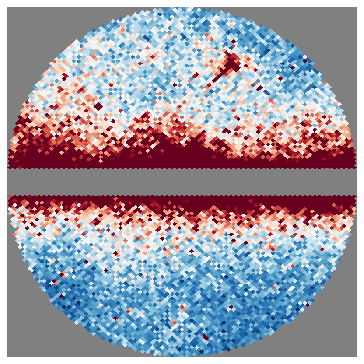

In [90]:
the_map = np.zeros(hp.nside2npix(128))
the_map[~masks_list[0]] = data_map[0][0].detach()
the_map = np.load("../data/fermi_data/fermidata_counts.npy")
the_map[roi_mask] = hp.UNSEEN
hp.cartview(hp.ma(the_map), lonra=[-25,25], latra=[-25,25], cmap=cmap, max=30, title=None, cbar=None)
plt.savefig("/Users/smsharma/Desktop/data.pdf")

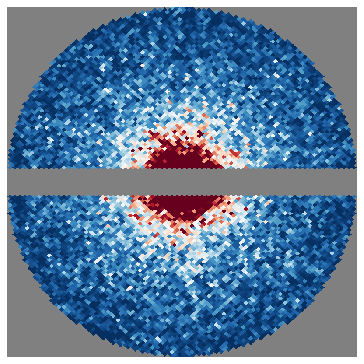

In [65]:
the_map = np.zeros(hp.nside2npix(128))
the_map[~masks_list[0]] = data_map[0][0].detach()
the_map[roi_mask] = hp.UNSEEN
hp.cartview(hp.ma(the_map), lonra=[-25,25], latra=[-25,25], cmap=cmap, max=50, title=None, cbar=None)
plt.savefig("/Users/smsharma/Desktop/gce.pdf")